# Imports

In [1]:
# imports
import numpy as np
import copy, pickle, os, joblib, sys, datetime, random, yaml

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams['axes.labelweight'] = 'bold'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

from utils import pre_process
from utils import evaluate
import submod

import logging
from itertools import product

from tqdm import tqdm

# Loading Hyperparameters from Config File

In [2]:
# Decided hyper-parameters
CONFIG_PATH = os.path.join("..", "..", "..", "config")
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config
config_fname = "config_btd.yaml"
config = load_config(config_fname)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
I_ind = config['methods']
sp_h = config['sp_h'] #height of the window 
sp_w = config['sp_w'] #width of the window  
w = config['w']
h = config['h']
epochs = config['epochs']#100
init_wt = config['init_wt']
delta = config['delta']#1e-5
#wt_reg = config['wt_reg']#1e-3
thresholds = config['thresholds']
all_paths = [os.path.join('..', '..', 'data', 'BTD', i) for i in config["all_paths"]]
device_I = 'cuda'
cmap = 'hot'
new_h = int(h/sp_h) #height of sub-sampled image
new_w = int(w/sp_w) #width of sub-sampled image
sq_n_sb_px = new_h # =new_h# square-root no. of sub-pixels

# Helper Functions
Includes code for
- Loading the classifier
- Defining transforms and loading the transformed images

In [3]:
# helper codes
def get_clf(device):
    model = models.vgg11(pretrained=True)
    last_layer_input = model.classifier[-1].in_features

    replaced_last_layer = nn.Linear(in_features=last_layer_input, out_features=2, bias=True)
    model.classifier[-1] = replaced_last_layer

    model.load_state_dict(torch.load(os.path.join("..", "..", "..", "models", "BTD", "classifier.pt")))
    model = model.to(device)
    return model

def get_transformed_img(image):
    transform=transforms.Compose([transforms.Grayscale(num_output_channels=3), 
                              transforms.Resize((w,h)),
                              transforms.ColorJitter(brightness=1, contrast=1, saturation=1), transforms.ToTensor()])
    return transform(image)

def get_inp(image, device):
    transformed_img = get_transformed_img(image)

    input = transformed_img.unsqueeze(0)
    input = input.to(device)
    return input

def get_paths(hp_index, img_name):
    for p in [os.path.join("..", "..", "..", "models", "BTD" , "DSFs", str(hp_index)), os.path.join("..", "..", "..", "models", "BTD" , "DSFs", str(hp_index))]:
        if not os.path.exists(p):
            os.makedirs(p)
        map_path = os.path.join("..", "..", "..", "logs", "BTD", str(hp_index), "{}.pickle".format(img_name))
        dsf_path = os.path.join("..", "..", "..", "models", "BTD" , "DSFs", str(hp_index), "{}.pt".format(img_name))
        curve_path = os.path.join("..","..","..","logs","BTD",str(hp_index),"curves")
    return map_path, dsf_path, curve_path

# Defining the DSF

In [4]:
#code for dsf
def sqrt(input):
    return torch.sqrt(input)

class DSF(nn.Module):
    def __init__(self):
        super(DSF, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = sqrt(x)
        x = self.fc2(x)
        x = sqrt(x)
        x = self.fc3(x)
        x = sqrt(x)
        x = self.fc4(x)
#         x = F.sigmoid(x)
        return x
    
class clamp_zero(object):
    def __init__(self):
        pass

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w.copy_(torch.clamp(w, min=0))
        if hasattr(module, 'bias'):
            w = module.bias.data
            w.copy_(torch.clamp(w, min=0))

def get_DSF(device, init_wt):
    f = DSF() 

    for W in f.parameters(): 
        if isinstance(init_wt, list):
            W.data.uniform_(init_wt[0], init_wt[1])
        else:
            W.data.uniform_(init_wt, init_wt)

    f = f.to(device)
    f = f.double()
    return f

# Producing the SEA Map and Computing AUPC

In [5]:
def train_dsf(model, cfg, img_path):
    ld1 = cfg['ld1']; ld2 = cfg['ld2']; wt_reg = cfg['wt_reg']
    torch.manual_seed(0); np.random.seed(0)
    clipper = clamp_zero()

    stime = datetime.datetime.now()
    image = Image.open(img_path)

    inp = get_inp(image, device)
    target_class, I_ALL = pre_process.get_predic_and_maps(model, inp, device_I, I_ind, device)

    # hard-thresholded maps
    ht = pre_process.final_ht_proc(sp_w, sp_h, thresholds, I_ALL)
    # sub-sampled hard-thresholded maps
    sub_h = pre_process.final_subI_proc(sp_w, sp_h, I_ALL)

    f = get_DSF(device, init_wt)
    optimizer = torch.optim.Adagrad(f.parameters(), lr_decay = 0.1, weight_decay = wt_reg) #torch.optim.Adam(f.parameters(), weight_decay = wt_reg)
    f.train()
    
    loss_plt=[]; loss1_plt = []; loss2_plt = []    
    for epoch in range(epochs):
        loss_1 = None; loss_2 = None
        Adic = submod.c_sb_mx(f, list(ht.keys()), sq_n_sb_px, device)#all A*'s at once
        if(isinstance(Adic,torch.Tensor)):
            skip_img = True
            break

        ASList = list(Adic.values())
        AList_f = f(torch.stack(ASList).double().view(len(ASList), 1, sq_n_sb_px, sq_n_sb_px).to(device))
        tensor_ht = {}
        # loss_1: loss with hard thresholded maps sub-sampled
        for xk, k in enumerate(ht):
            tensor_ht[k] = [torch.Tensor(ht) for ht in ht[k]] # hard thresholded sub-sampled maps(of all methods) having cardinality k
            all_S_f = f(torch.stack(tensor_ht[k]).double().view(len(tensor_ht[k]), 1, sq_n_sb_px, sq_n_sb_px).to(device))
            for xs, _ in enumerate(tensor_ht[k]):
                to_add = AList_f[xk]-all_S_f[xs]+delta
                if to_add>0:
                    if loss_1 is None:
                        loss_1 = to_add
                    else:
                        loss_1 = loss_1+to_add
        # loss_2: loss with original attribution maps
        ones_f = f(torch.ones(sq_n_sb_px*sq_n_sb_px).double().view(1, 1, sq_n_sb_px, sq_n_sb_px).to(device))
        tensor_sub_h = [torch.Tensor(s_h) for s_h in sub_h]
        sub_h_f = f(torch.stack(tensor_sub_h).double().view(len(tensor_sub_h), 1, sq_n_sb_px, sq_n_sb_px).to(device))
        for xs_h, _ in enumerate(tensor_sub_h):
            to_also_add = ones_f-sub_h_f[xs_h]
            if to_also_add>0:
                if loss_2 is None:
                    loss_2 = to_also_add
                else:
                    loss_2 = loss_2+to_also_add
        loss = None
        if loss_1 is not None:
            loss = ld1*loss_1
        if loss_2 is not None:
            if loss is not None:
                loss = loss+ld2*loss_2
            else:
                loss = ld2*loss_2
        if loss is None:
            break
        loss_plt.append(loss.item())
        f.zero_grad()
        loss.backward()
        optimizer.step()
        f.apply(clipper)
    
    temp_transform = transforms.Compose([
        transforms.Resize((w,h))
    ])
    img_temp = temp_transform(image)
    sea_attr = submod.sea_nn(f, sq_n_sb_px, sp_w, sp_h, device)
    
    all_maps = {'sea':sea_attr}
    aupc_scores,_ = evaluate.AUC(model, inp, all_maps, device, target_class)
    sea_aupc_score = aupc_scores['sea']['aupc']
    
    print(f'AUPC Score: {sea_aupc_score}')
        
    plt.imshow(image)
    plt.title('Input Image')
    plt.show()
    
    plt.imshow(sea_attr,cmap='hot')
    plt.title('SEA Map')
    plt.show()
    
    plt.imshow(sea_attr,cmap='hot')
    plt.imshow(img_temp,alpha=0.3)
    plt.title('SEA Map overlaid on Input Image')
    plt.show()

AUPC Score: 3.935549191199243


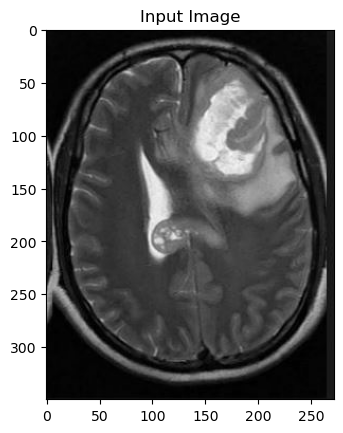

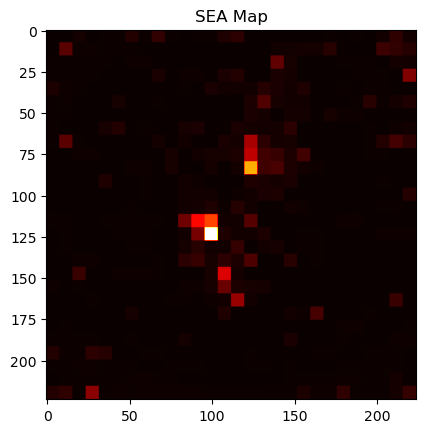

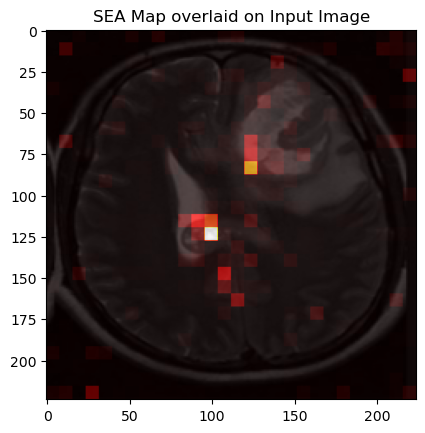

In [7]:
cfg = {'ld1': 100, 'ld2': 100, 'wt_reg': 1e-3}
model = get_clf(device='cuda')
train_dsf(model,cfg,'../../data/BTD/data/test/patients/Y86.JPG')